## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

#建立神經網路
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.75, 0.5]
reduce_lr_patient = [2e-12, 1e-12]

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, reduce_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=reduce_patient, 
                              monitor='val_loss', 
                              patience=5, 
                              verbose=1)

    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.75, reduce_patient: 0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 13s 255us/step - loss: 1.2804 - acc: 0.5554 - val_loss: 1.4934 - val_acc: 0.4785
Epoch 12/25
50000/50000 [==============================] - 13s 258us/step - loss: 1.2529 - acc: 0.5662 - val_loss: 1.4803 - val_acc: 0.4865
Epoch 13/25
50000/50000 [==============================] - 12s 243us/step - loss: 1.2285 - acc: 0.5736 - val_loss: 1.4609 - val_acc: 0.4951
Epoch 14/25
50000/50000 [==============================] - 12s 246us/step - loss: 1.2035 - acc: 0.5838 - val_loss: 1.4649 - val_acc: 0.4865
Epoch 15/25
50000/50000 [==============================] - 13s 250us/step - loss: 1.1799 - acc: 0.5914 - val_loss: 1.4612 - val_acc: 0.4865
Epoch 16/25
50000/50000 [==============================] - 13s 257us/step - loss: 1.1557 - acc: 0.6013 - val_loss: 1.4532 - val_acc: 0.4933
Epoch 17/25
50000/50000 [==============================] - 12s 250us/step - loss: 1.1351 - acc: 0.6086 - val_loss: 1.4576 - val_acc: 0.4940
Epoch 18/25
50000/50000 [=======

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 18s 368us/step - loss: 2.2877 - acc: 0.2451 - val_loss: 2.2556 - val_acc: 0.2928
Epoch 2/25
50000/50000 [==============================] - 13s 257us/step - loss: 1.7931 - acc: 0.3745 - val_loss: 1.8706 - val_acc: 0.3677
Epoch 3/25
50000/50000 [==============================] - 13s 256us/step - loss: 1.6619 - acc: 0.4161 - val_loss: 1.7214 - val_acc: 0.3995
Epoch 4/25
50000/50000 [==============================] - 13s 253us/step - loss: 1.5862 - acc: 0.4431 - val_loss: 1.6468 - val_acc: 0.4257
Epoch 5/25
50000/50000 [==============================] - 13s 258us/step - loss: 1.5305 - acc: 0.4630 - val_loss: 1.6307 - val_acc: 0.4267
Epoch 6/25
50000/50000 [==============================] - 13s 260us/step - loss: 1.4871 - acc: 0.4792 - val_loss: 1.5991 - val_acc: 0.4407
Epoch 7/25
50000/50000 [==============================] - 13s 256us/step - loss: 1.4498 - acc: 0.4912 - val_loss: 1.

Epoch 23/25
50000/50000 [==============================] - 13s 257us/step - loss: 0.4872 - acc: 0.8400 - val_loss: 1.9195 - val_acc: 0.4456
Epoch 24/25
50000/50000 [==============================] - 13s 262us/step - loss: 0.4572 - acc: 0.8489 - val_loss: 2.0306 - val_acc: 0.4601

Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.0005625000048894435.
Epoch 25/25
50000/50000 [==============================] - 13s 265us/step - loss: 0.3885 - acc: 0.8773 - val_loss: 1.8467 - val_acc: 0.4812
Numbers of exp: 5, reduce_factor: 0.75, reduce_patient: 0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)     

Epoch 8/25
50000/50000 [==============================] - 13s 263us/step - loss: 1.1278 - acc: 0.6056 - val_loss: 1.5287 - val_acc: 0.4590
Epoch 9/25
50000/50000 [==============================] - 13s 269us/step - loss: 1.0827 - acc: 0.6209 - val_loss: 1.5687 - val_acc: 0.4529
Epoch 10/25
50000/50000 [==============================] - 14s 271us/step - loss: 1.0381 - acc: 0.6395 - val_loss: 1.5977 - val_acc: 0.4526
Epoch 11/25
50000/50000 [==============================] - 13s 263us/step - loss: 1.0089 - acc: 0.6505 - val_loss: 1.4800 - val_acc: 0.4883
Epoch 12/25
50000/50000 [==============================] - 13s 266us/step - loss: 0.9653 - acc: 0.6663 - val_loss: 1.4450 - val_acc: 0.4944
Epoch 13/25
50000/50000 [==============================] - 13s 269us/step - loss: 0.9260 - acc: 0.6791 - val_loss: 1.4560 - val_acc: 0.4953
Epoch 14/25
50000/50000 [==============================] - 13s 266us/step - loss: 0.8889 - acc: 0.6937 - val_loss: 1.4913 - val_acc: 0.4808
Epoch 15/25
50000/5000

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 21s 414us/step - loss: 1.7966 - acc: 0.3755 - val_loss: 2.0386 - val_acc: 0.3143
Epoch 2/25
50000/50000 [==============================] - 14s 272us/step - loss: 1.5345 - acc: 0.4580 - val_loss: 2.1065 - val_acc: 0.3184
Epoch 3/25
50000/50000 [==============================] - 14s 273us/step - loss: 1.4312 - acc: 0.4944 - val_loss: 2.2584 - val_acc: 0.2763
Epoch 4/25
50000/50000 [==============================] - 13s 260us/step - loss: 1.3541 - acc: 0.5226 - val_loss: 1.8990 - val_acc: 0.3600
Epoch 5/25
50000/50000 [==============================] - 13s 262us/step - loss: 1.2973 - acc: 0.5406 - val_loss: 2.0344 - val_acc: 0.3318
Epoch 6/25
50000/50000 [==============================] - 13s 260us/step - loss: 1.2415 - acc: 0.5612 - val_loss: 2.1506 - val_acc: 0.2892
Epoch 7/25
50000/50000 [==============================] - 13s 267us/step - loss: 1.2013 - acc: 0.5753 - val_loss: 2.

50000/50000 [==============================] - 13s 270us/step - loss: 0.6644 - acc: 0.7793 - val_loss: 1.8506 - val_acc: 0.4429
Epoch 23/25
50000/50000 [==============================] - 13s 266us/step - loss: 0.6343 - acc: 0.7903 - val_loss: 1.8498 - val_acc: 0.4350
Epoch 24/25
50000/50000 [==============================] - 13s 266us/step - loss: 0.6068 - acc: 0.7978 - val_loss: 1.6877 - val_acc: 0.4763
Epoch 25/25
50000/50000 [==============================] - 13s 262us/step - loss: 0.5828 - acc: 0.8071 - val_loss: 1.8656 - val_acc: 0.4573
Numbers of exp: 10, reduce_factor: 0.50, reduce_patient: 0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_______________________________________________________________

Epoch 8/25
50000/50000 [==============================] - 13s 260us/step - loss: 1.2249 - acc: 0.5763 - val_loss: 1.5938 - val_acc: 0.4380
Epoch 9/25
50000/50000 [==============================] - 13s 266us/step - loss: 1.1849 - acc: 0.5917 - val_loss: 1.6477 - val_acc: 0.4352
Epoch 10/25
50000/50000 [==============================] - 13s 267us/step - loss: 1.1469 - acc: 0.6066 - val_loss: 1.5353 - val_acc: 0.4591
Epoch 11/25
50000/50000 [==============================] - 13s 259us/step - loss: 1.1154 - acc: 0.6172 - val_loss: 1.7485 - val_acc: 0.4063
Epoch 12/25
50000/50000 [==============================] - 13s 269us/step - loss: 1.0828 - acc: 0.6299 - val_loss: 1.5619 - val_acc: 0.4532
Epoch 13/25
50000/50000 [==============================] - 14s 274us/step - loss: 1.0489 - acc: 0.6444 - val_loss: 1.5176 - val_acc: 0.4691
Epoch 14/25
50000/50000 [==============================] - 13s 268us/step - loss: 1.0160 - acc: 0.6570 - val_loss: 1.5680 - val_acc: 0.4635
Epoch 15/25
50000/5000

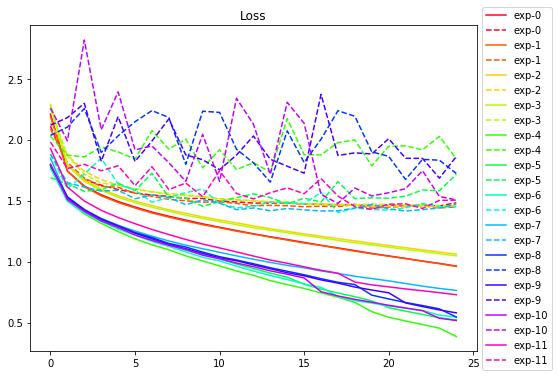

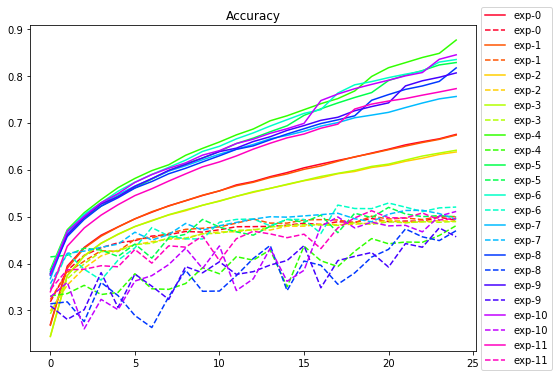

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()